
In the following, we run Twin Delayed Deep Deterministic Policy Gradient (TD3).

# Neural Network Structure

We define classes for the actor and critic networks. In TD3, we prepare two neural networks for the critic.

In [ ]:
import copy
import numpy as np
import tensorflow as tf

class Critic(tf.keras.Model):
    def __init__(self):
        super(Critic, self).__init__()
        self.f1 = tf.keras.layers.Dense(256, activation='relu')
        self.f2 = tf.keras.layers.Dense(256, activation='relu')
        self.f3 = tf.keras.layers.Dense(1, activation=None)

        self.f4 = tf.keras.layers.Dense(256, activation='relu')
        self.f5 = tf.keras.layers.Dense(256, activation='relu')
        self.f6 = tf.keras.layers.Dense(1, activation=None)

    def predict(self, state, action):
        x = self.f1(tf.concat([state, action], axis=1))
        x = self.f2(x)
        q1 = self.f3(x)

        x2 = self.f4(tf.concat([state, action], axis=1))
        x2 = self.f5(x2)
        q2 = self.f6(x2)

        return q1, q2

    def Q1(self, state, action):
        x = self.f1(tf.concat([state, action], axis=1))
        x = self.f2(x)
        q1 = self.f3(x)

        return q1

class Actor(tf.keras.Model):
  def __init__(self, action_dim, max_action):
    super(Actor, self).__init__()
    self.f1 = tf.keras.layers.Dense(256, activation='relu')
    self.f2 = tf.keras.layers.Dense(256, activation='relu')
    self.mu =  tf.keras.layers.Dense(action_dim, activation='tanh')

    self.max_action = max_action

  def predict(self, state):
    x = self.f1(state)
    x = self.f2(x)
    a = self.max_action * self.mu(x)

    return a


We then define the class for TD3. The update of the actor and critic is defined in "def train()".

In [ ]:
class TD3(object):
    def __init__(
            self,
            state_dim,
            action_dim,
            max_action,
            discount=0.99,
            tau=0.005,
            policy_noise=0.2,
            noise_clip=0.5,
            policy_freq=2
    ):

        self.actor = Actor(action_dim, max_action)
        self.actor_target = copy.deepcopy(self.actor)
        self.actor_optimizer = tf.keras.optimizers.Adam(3e-4)

        self.critic = Critic()
        self.critic_target = copy.deepcopy(self.critic)
        self.critic_optimizer = tf.keras.optimizers.Adam(3e-4)

        self.actor.compile(optimizer=self.actor_optimizer)
        self.critic.compile(optimizer=self.critic_optimizer)

        self.max_action = max_action
        self.discount = discount
        self.tau = tau
        self.policy_noise = policy_noise
        self.noise_clip = noise_clip
        self.policy_freq = policy_freq

        self.total_it = 0

    def select_action(self, state):
        state = tf.convert_to_tensor([state], dtype=tf.float32)
        return tf.squeeze(self.actor.predict(state), axis=1)

    def update_actor_target_network(self):
        actor_weights = self.actor.get_weights()
        actor_target_weights = self.actor_target.get_weights()
        for i in range(len(actor_weights)):
            actor_target_weights[i] = self.tau * actor_weights[i] + (1 - self.tau) * actor_target_weights[i]

        self.actor_target.set_weights(actor_target_weights)

    def update_critic_target_network(self):
        critic_weights = self.critic.get_weights()
        critic_target_weights = self.critic_target.get_weights()
        for i in range(len(critic_weights)):
            critic_target_weights[i] = self.tau * critic_weights[i] + (1 - self.tau) * critic_target_weights[i]

        self.critic_target.set_weights(critic_target_weights)

    def train(self, replay_buffer, batch_size=100):
        self.total_it += 1

        # Sample replay buffer
        state, action, next_state, reward, not_done = replay_buffer.sample(batch_size)

        with tf.GradientTape() as tape_critic:
            target_actions = self.actor_target.predict(next_state)

            noise = tf.clip_by_value(tf.random.normal(shape=[*np.shape(target_actions)], mean=0.0, stddev=self.policy_noise),
                                     -self.noise_clip, self.noise_clip)

            next_action = (tf.clip_by_value(target_actions + noise, -self.max_action, self.max_action))

            target_Q1, target_Q2 = self.critic_target.predict(next_state, next_action)
            target_Q = tf.math.minimum(target_Q1, target_Q2)
            target_Q = reward + not_done * self.discount * target_Q

            current_Q1, current_Q2 = self.critic.predict(state, action)

            critic_loss = tf.keras.losses.MSE(current_Q1, tf.stop_gradient(target_Q)) \
                          + tf.keras.losses.MSE(current_Q2, tf.stop_gradient(target_Q))

            grads_critic = tape_critic.gradient(critic_loss, self.critic.trainable_variables)

        self.critic_optimizer.apply_gradients(zip(grads_critic, self.critic.trainable_variables))

        if self.total_it % self.policy_freq == 0:
            with tf.GradientTape() as tape_actor:
                actor_loss = - tf.math.reduce_mean(self.critic.Q1(state, self.actor.predict(state)))


            grads_actor = tape_actor.gradient(actor_loss, self.actor.trainable_variables)
            self.actor_optimizer.apply_gradients(zip(grads_actor, self.actor.trainable_variables))

            self.update_actor_target_network()
            self.update_critic_target_network()



    def save_model(self, iter, seed, env_name, foldername='./model/td3'  ):
        try:
            import pathlib
            pathlib.Path(foldername).mkdir(parents=True, exist_ok=True)
            self.actor.save_weights(
                       foldername + '/td3_actor_'+ env_name +
                       '_seed' + str(seed) + '_iter' + str(iter) + '.tf')

            print('models is saved for iteration', iter )

        except:
            print("A result directory does not exist and cannot be created. The trial results are not saved")

    def load_model(self, iter, seed, env_name, foldername='model/td3'  ):
        self.actor.load_weights(foldername + '/td3_actor_' + env_name +
            '_seed' + str(seed) + '_iter' + str(iter) + '.tf')
        

# Replay Buffer

The samples collected through trials and errors are stored in the replay buffer. "def sample()" is a function that randomly samples a batch of samples from the replay buffer. 

In [ ]:
import numpy as np
import tensorflow as tf

class ReplayBuffer(object):
    def __init__(self, state_dim, action_dim, max_size=int(1e6)):
        self.max_size = max_size
        self.ptr = 0
        self.size = 0

        self.state = np.zeros((max_size, state_dim))
        self.action = np.zeros((max_size, action_dim))
        self.next_state = np.zeros((max_size, state_dim))
        self.reward = np.zeros((max_size, 1))
        self.not_done = np.zeros((max_size, 1))

    def add(self, state, action, next_state, reward, done):
        self.state[self.ptr] = state
        self.action[self.ptr] = action
        self.next_state[self.ptr] = next_state
        self.reward[self.ptr] = reward
        self.not_done[self.ptr] = 1. - done

        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample(self, batch_size):
        ind = np.random.randint(0, self.size, size=batch_size)

        return (
            tf.convert_to_tensor(self.state[ind], dtype=tf.float32),
            tf.convert_to_tensor(self.action[ind], dtype=tf.float32),
            tf.convert_to_tensor(self.next_state[ind], dtype=tf.float32),
            tf.convert_to_tensor(self.reward[ind], dtype=tf.float32),
            tf.convert_to_tensor(self.not_done[ind], dtype=tf.float32)
        )

# Training and evaluating procedures

We define a function for evaluating the policy. When evaluating the trained policy, we evaluate the performance without the exploration noise.


In [ ]:
def evaluate_greedy(env_test, agent, args, test_iter, test_n, state_dim):

    state_test = env_test.reset()
    return_epi_test = 0
    for t_test in range(int(args['max_episode_len'])):
        if args['render_env']:
                env_test.render()

        action_test = agent.select_action(np.reshape(state_test, (1, state_dim)))
        state_test2, reward_test, terminal_test, info_test = env_test.step(action_test)
        state_test = state_test2
        return_epi_test = return_epi_test + reward_test
        if terminal_test:
            break

    print('test_iter:{:d}, nn:{:d}, return_epi_test: {:d}'.format(int(test_iter), int(test_n),
                                                                      int(return_epi_test)))

    return return_epi_test

Below is the training procedure. We collect samples through trials and errors and store them in the replay buffer. The policy is trained once after every one time step.

In [ ]:
def train(env, env_test, agent, args, index):

    # Initialize replay memory
    total_step_cnt = 0
    epi_cnt = 0
    test_iter = 0
    return_test = np.zeros((np.ceil(int(args['total_step_num']) / int(args['eval_step_freq'])).astype('int') + 1))

    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    max_action = float(env.action_space.high[0])

    replay_buffer = ReplayBuffer(state_dim, action_dim)

    while total_step_cnt in range( int(args['total_step_num']) ):

        state = env.reset()
        ep_reward = 0
        T_end = False

        for t in range(int(args['max_episode_len'])):

            # Select action randomly or according to policy
            if total_step_cnt < int(args['start_timesteps']):
                action = env.action_space.sample()
            else:
                action = np.clip(
                        agent.select_action(np.array(state))
                        + np.random.normal(0, max_action * float(args['expl_noise']), size=action_dim),
                        -max_action, max_action)

            state2, reward, terminal, info = env.step(action)
            terminal_bool = float(terminal) if t < int(args['max_episode_len']) else 0

            # Store data in replay buffer
            replay_buffer.add(state, action, state2, reward, terminal_bool)

            # Train agent after collecting sufficient data
            if total_step_cnt >= int(args['start_timesteps']):
                for i in range(int(args['update_freq'])):
                    agent.train(replay_buffer, int(args['batch_size']))

            if t == int(args['max_episode_len']) - 1:
                T_end = True

            state = state2
            ep_reward += reward
            total_step_cnt += 1

            # Evaluate the deterministic policy
            if total_step_cnt >= test_iter * int(args['eval_step_freq']) or total_step_cnt == 1:
                print('total_step_cnt', total_step_cnt)
                print('evaluating the deterministic policy...')
                for test_n in range(int(args['test_num'])):
                    return_epi_test = evaluate_greedy(env_test, agent, args, test_iter, test_n, state_dim)

                    # Store the average of returns over the test episodes
                    return_test[test_iter] = return_test[test_iter] + return_epi_test / float(args['test_num'])

                print('return_test[{:d}] {:d}'.format(int(test_iter), int(return_test[test_iter])))
                test_iter += 1

            if total_step_cnt % int(args['model_save_freq'])==0:
                    agent.save_model(iter=test_iter, seed=int(index), env_name=args['env'])


            if terminal or T_end:
                epi_cnt += 1
                print('| Reward: {:d} | Episode: {:d} | Total step num: {:d} |'.format(int(ep_reward), epi_cnt, total_step_cnt ))

                break

    return return_test

Main funciton. To manage the hyperparamters of TD3, we use argeparse.
We use a task in OpenAI Gym (https://gym.openai.com/).

In [ ]:
import numpy as np
import gym

import argparse

parser = argparse.ArgumentParser()

# run parameters
parser.add_argument('--env', help='choose the gym env- tested on {Pendulum-v0}')
parser.add_argument('--env-id', type=int, default=0, help='choose the gym env- tested on {Pendulum-v0}')
parser.add_argument('--random-seed', help='random seed for repeatability', default=1)
parser.add_argument('--max-episodes', help='max num of episodes to do while training', default=1001) 
parser.add_argument('--max-episode-len', help='max length of 1 episode', default=1000)
parser.add_argument('--trial-num', help='number of trials', default=3)
parser.add_argument('--render-env', help='render the gym env', action='store_true')
parser.add_argument('--total-step-num', help='total number of time steps', default=25000)
parser.add_argument('--eval-step-freq', help='frequency of evaluating the policy', default=5000)
parser.add_argument('--test-num', help='number of test episodes', default=10)

parser.add_argument('--result-file', help='file name for storing results from multiple trials',
                    default='./results/trials/td3/trials_td3_')
parser.add_argument('--trial-idx', help='index of trials', default=0)
parser.add_argument('--monitor-dir', help='directory for recording', default='results/video/td3')
parser.add_argument('--model-save-freq', help='frequency of evaluating the policy', default=10000)
parser.add_argument('--model-folder',  default='./model/td3')

parser.add_argument("--start_timesteps", default=1e4, type=int)  # How many time steps purely random policy is run for
parser.add_argument("--expl_noise", default=0.1, type=float)  # Std of Gaussian exploration noise
parser.add_argument("--batch_size", default=256, type=int)  # Batch size for both actor and critic
parser.add_argument("--update_freq", default=1, type=int)  # Number of policy updates

parser.set_defaults(render_env=False)

args_tmp, unknown = parser.parse_known_args()

if args_tmp.env is None:
    env_dict = {0 : "Pendulum-v0",
    }
    args_tmp.env = env_dict[args_tmp.env_id]
args = vars(args_tmp)

return_set=[]
for ite in range(int(args['trial_num'])):
    print('Trial Number:', ite)

    index = int(ite) + int(args['trial_idx'])
    env = gym.make(args['env'])

    np.random.seed(index )
    env.seed(index)

    env_test = gym.make(args['env'])
    env_test.seed(index)

    print('action_space.shape', env.action_space.shape)
    print('observation_space.shape', env.observation_space.shape)
    action_bound = float(env.action_space.high[0])

    assert (env.action_space.high[0] == -env.action_space.low[0])

    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]

    agent = TD3(state_dim=state_dim, action_dim=action_dim, max_action=action_bound)

    step_R_i = train(env, env_test, agent, args, index)
    return_set.append(step_R_i)

    result_path = "./results/trials/td3"
    result_filename = args['result_file'] +  \
                      '_update_freq_' + str(int(args['update_freq'])) + '_' + args['env'] +  \
                      '_trial_idx_' + str(index) + '.txt'
    try:
        import pathlib
        pathlib.Path(result_path).mkdir(parents=True, exist_ok=True)
        np.savetxt(result_filename, np.asarray(step_R_i))
        print('The result of the trial no.' + str(index) + ' was saved.')
    except:
        print("A result directory does not exist and cannot be created. The trial results are not saved")



    



Trial Number: 0
action_space.shape (1,)
observation_space.shape (3,)
total_step_cnt 1
evaluating the deterministic policy...
test_iter:0, nn:0, return_epi_test: -1749
test_iter:0, nn:1, return_epi_test: -959
test_iter:0, nn:2, return_epi_test: -1636
test_iter:0, nn:3, return_epi_test: -1071
test_iter:0, nn:4, return_epi_test: -1764
test_iter:0, nn:5, return_epi_test: -1782
test_iter:0, nn:6, return_epi_test: -965
test_iter:0, nn:7, return_epi_test: -1770
test_iter:0, nn:8, return_epi_test: -961
test_iter:0, nn:9, return_epi_test: -1791
return_test[0] -1445
| Reward: -1586 | Episode: 1 | Total step num: 200 |
| Reward: -1206 | Episode: 2 | Total step num: 400 |
| Reward: -1534 | Episode: 3 | Total step num: 600 |
| Reward: -779 | Episode: 4 | Total step num: 800 |
| Reward: -1729 | Episode: 5 | Total step num: 1000 |
| Reward: -1458 | Episode: 6 | Total step num: 1200 |
| Reward: -742 | Episode: 7 | Total step num: 1400 |
| Reward: -1612 | Episode: 8 | Total step num: 1600 |
| Reward: -

We plot the results of the training using matplotlib.

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


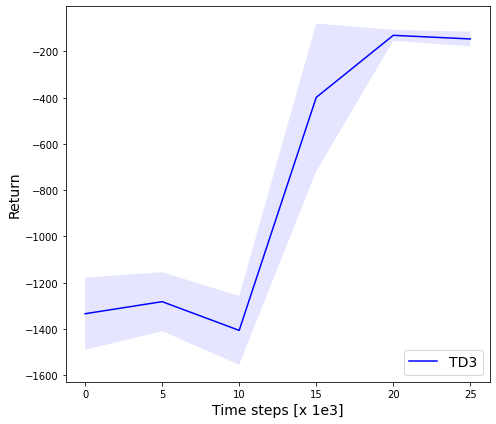

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = 'Times New Roman'

figure(figsize=(7, 6))

t = np.arange(0, int(args['total_step_num']) + 1, int(args['eval_step_freq'])) * 0.001

mean = np.mean(np.asarray(return_set), axis=0)
std = np.std(np.asarray(return_set), axis=0)
color = 'b'
label = 'TD3'
plt.plot(t, mean, color, label=label)
plt.fill(np.concatenate([t, t[::-1]]), np.concatenate([mean - 1.9600 * std,
                                      (mean + 1.9600 * std)[::-1]]), alpha=.1, fc=color, ec='None')

plt.xlabel('Time steps [x 1e3]', fontsize=14)
plt.ylabel('Return', fontsize=14)
plt.legend(loc='lower right', fontsize=14)

    
plt.tight_layout()
plt.show()